# Dataset Description


**train.csv**
The training data, comprising time series of features store_nbr, family, and onpromotion as well as ***the target sales***.
* **store_nbr** identifies the store at which the products are sold.
* **family** identifies the type of product sold.
* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

* **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

**test.csv**
* The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
* The dates in the test data are for the 15 days after the last date in the training data.

**stores.csv**
Store metadata, including:
* **city**
* **state**
* **type**
* **cluster**: a grouping of similar stores.

**transactions.csv**
* date
* store_nbr
* transactions

**oil.csv**
* Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**
* Holidays and Events, with metadata
* NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
* Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional Notes**
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Import libraries

In [ ]:
# "magic commands" to enable autoreload of the imported packages
# %load_ext autoreload
# %reload_ext autoreload
# %autoreload 2

import re
from pathlib import Path
import joblib

# Data Manipulation
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision 

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Sklearn 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler  
from sklearn.pipeline import make_union, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.base import clone

set_config(transform_output="pandas")

# Sktime
!pip install sktime --quiet
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utility functions

In [ ]:
#### Function to reduce memory usage ####
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_memory_usage(df, verbose=True):
    numerics = ['int32', 'int64', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load the full base dataset

In [ ]:
# Directory containing the base dataset for feature engineering
base_data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/base_data")
# Load the base dataset
df_full = pd.read_parquet(
    path=base_data_dir, 
    engine="pyarrow"
)       

In [ ]:
# Make a copy
df = df_full.copy()
del df_full

# Select and reorder the columns 
columns = [
           'date', 'store_nbr', 'family', 
           'sales', 'onpromotion', 'transactions', 'oil_price_interpolated',    # NOTE: each value in the "transactions" column is the number of transactions per store for a given date
           'city', 'state', 'type', 'cluster', 
           'is_Local_holiday', 'is_Regional_holiday', 'is_National_holiday', 
           'wage_day', 'earthquake_day', 'earthquake_impact'
           ]

df = df[columns]

# Create "id" = "store_nbr" + "family" 
df["id"] = df[["store_nbr", "family"]].apply("_".join, axis=1)

# Set "id" and "date" as index (needed for sktime tranformers)
df = df.set_index(["id", "date"]).sort_index()

# Check
df.head()

store_nbr      family  sales  onpromotion  \
id            date                                                   
10_AUTOMOTIVE 2013-01-01        10  AUTOMOTIVE   0.00         0.00   
              2013-01-02        10  AUTOMOTIVE   3.00         0.00   
              2013-01-03        10  AUTOMOTIVE   2.00         0.00   
              2013-01-04        10  AUTOMOTIVE   2.00         0.00   
              2013-01-05        10  AUTOMOTIVE   0.00         0.00   

                          transactions  oil_price_interpolated   city  \
id            date                                                      
10_AUTOMOTIVE 2013-01-01          0.00                   93.14  Quito   
              2013-01-02       1293.00                   93.14  Quito   
              2013-01-03       1157.00                   92.97  Quito   
              2013-01-04        970.00                   93.12  Quito   
              2013-01-05       1269.00                   93.12  Quito   

                              state type cluster is_Local_holiday  \
id            date                                                  
10_AUTOMOTIVE 2013-01-01  Pichincha    C      15       no_holiday   
              2013-01-02  Pichincha    C      15       no_holiday   
              2013-01-03  Pichincha    C      15       no_holiday   
              2013-01-04  Pichincha    C      15       no_holiday   
              2013-01-05  Pichincha    C      15       no_holiday   

                         is_Regional_holiday is_National_holiday wage_day  \
id            date                                                          
10_AUTOMOTIVE 2013-01-01          no_holiday            National      yes   
              2013-01-02          no_holiday          no_holiday       no   
              2013-01-03          no_holiday          no_holiday       no   
              2013-01-04          no_holiday          no_holiday       no   
              2013-01-05          no_holiday          no_holiday       no   

                         earthquake_day earthquake_impact  
id            date                                         
10_AUTOMOTIVE 2013-01-01             no                no  
              2013-01-02             no                no  
              2013-01-03             no                no  
              2013-01-04             no                no  
              2013-01-05             no                no

# Feature engineering summary

|              |                                                              |                                        |
| ------------ | ------------------------------------------------------------ | -------------------------------------- |
| **TARGET**   | "sales"                                                      | Create lag and rolling window features |
| **FEATURES** |                                                              |                                        |
| Categorical  | "family", "store_nbr", "city", "state", "type", "cluster"          | Mean encoding with expanding window    |
| Categorical  | 'is_Local_holiday' (binary),    is_Regional_holiday' (binary),   'is_National_holiday' (binary),    'earthquake_day' (binary),    'earthquake_impact' (binary) ,   'wage_day' (binary) |                                        |
| Numeric      | "onpromotion",    "oil_price_interpolated"                   |                                        |
| Numeric      | "transactions"                                               | Create an one-day lag feature |
| Datetime     | "date"                                                       | Create time and date features          |

**NUMERIC FEATURES:**

* "onpromotion" = the total number of items in a product family that were being promoted at a store at a given date.
* "transactions" = the total number of transactions per store at a given date. (each value in the "transactions" column is the number of transactions per store for a given date)
* "oil_price_interpolated"

**LAG FEATURES:**

Lags are past values of the TARGET/ FEATURE.


**ROLLING WINDOW FEATURES:** 

We will create rolling window features to summarize more than one past value into a single feature (where we compute statistics) using a window over the past data. 
  * How we pick the window size: we try nested window features where we use multiple window sizes on different time scales (e.g. weeks, months) to capture information at those time scales. For example, patterns in short term (weeks) vs long term (months) in the target and feature.
  * Statistics: We will keep it simple and use mean and standard deviation. If the accuracy is not good enough, we can consider add more statistics.
      * Mean: moving average to smooth the data
      * Standard deviation: measures volatility
NOTE: (1) For forecasting, we need to use the values of the features that we know at predict time to avoid data leakage. So we need to shift the output of the row down by one (2) For the edge cases (NaN), we will use smaller window sizes at the edges and impute the missing data (Another option is to treat them as missing data and drop/impute)


**MEAN ENCODING USING EXPANDING WINDOW FEATURES:** 

We will manually create mean encoding features using expanding window for 4 categorical features: "family", "store_nbr", "city", "state". This implementation helps avoid look-ahead bias.
* Mean encoding is similar to label encoding, except here labels are correlated directly with the target. For example, in mean target encoding for each category in the feature label is decided with the mean value of the target variable on a training data/ testing data.
* The advantages of the mean target encoding are that it does not affect the volume of the data and helps in faster learning.
* NOTE: (1) To avoid data leakage, we need to shift the output of the row down by one. (2) We have multiple categorical features, the expanding window for each feature will be different from each other. 



**TIME FEATURE:**

We create a time feature (time since start) from the Datetime Index
* The "sales" series seems to have some changepoints (changepoint = abrupt change in any properties of a time series (e.g. trend, seasonality, autoregressive properties)).
* Thus, we include this time feature that would allow our tree-based model to segment over time, and isolate changepoints, outliers, and other interesting periods during training.    


**DATE FEATURES:**

We create several date features from the Datetime Index
* day_of_week
* is_weekend
* day_of_month
* week_of_month
* week_of_year
* month_of_year
* year


**FEATURE SELECTION:**

We will use **feature selection** to reduce the number of features.

-------------
**OTHER:**
* We can use `clone` to return an unfitted version of the pipeline (from sklearn.base import clone // pipeline = clone(pipeline)) 
* We have not considered DISTRIBUTED LAGS (...): the impact of ... on day t will probably last for multiple days into future after time t. Thus, The sales on a given day is influenced by ... on previous days as well as the same day
* We have not considered WEIGHTED WINDOW FEATURES: to be more sensitive to recent observations, e.g., to quickly pick up changes in trend. We assigns weights to the window (more weight to recent observations when computing a window feature)  
  * How to pick the weight: 
    * Exponential: Weight decays exponentially. We can specify parameter: rate of decay. E.g. Exponential weighted window (mean) 
    * Exponential weighted moving average (EWMA) at time t


## List the features
We just check the numeric and categorical features. Run the code will not make any changes to df.







In [ ]:
display(df.columns)

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'transactions',
       'oil_price_interpolated', 'city', 'state', 'type', 'cluster',
       'is_Local_holiday', 'is_Regional_holiday', 'is_National_holiday',
       'wage_day', 'earthquake_day', 'earthquake_impact'],
      dtype='object')

In [ ]:
def list_categories(column_names, df=df): 
  for col in df[column_names].columns:
    print(col, "\n", df[col].cat.categories, "\n")

def list_values(column_names, df=df): 
  for col in df[column_names].columns:
    print(col, "\n", df[col].unique(), "\n")

### Categorical features  

In [ ]:
# Family and store_nbr features 
list_categories(["family", "store_nbr"])

In [ ]:
# Location features
list_categories(['city', 'state', 'type', 'cluster'])

In [ ]:
# Holiday features 
list_categories(['is_Local_holiday', 'is_Regional_holiday', 'is_National_holiday'])

In [ ]:
# Earthquake and Wage_day features (Binary)
list_categories(['earthquake_day', 'earthquake_impact', 'wage_day'])

### Numerical features 

* "transactions" = the total number of transactions per store at a given date. (each value in the "transactions" column is the number of transactions per store for a given date)

* "onpromotion" = the total number of items in a product family that were being promoted at a store at a given date.

* "oil_price_interpolated"

In [ ]:
list_values(["onpromotion"])
df[["transactions", "onpromotion", "oil_price_interpolated"]]

# **PART 1**

## Step 1 - EXPONENTIAL WEIGHTED WINDOW FEATURES

### 1 - Create expanding window features with exponential weights: mean and standard deviation
Exponentially Weighted Moving Average (EWMA), is also known as an exponential moving average (EMA).
EWMA applies weights to the values of a time series. More weight is applied to more recent data points, making them more relevant for future forecasts.

In [ ]:
span = 7                  #corresponds to an “N-day EW moving average”
alpha = 2 / (span + 1)    #the smoothing factor 

result = df["sales"].ewm(span=7, adjust=False).agg(["mean", "std"]).shift(1) 
result = result.add_prefix(f"sales_ewma{span}_")

df = df.join(result, how="left")
df

store_nbr      family  sales  onpromotion  \
id            date                                                   
10_AUTOMOTIVE 2013-01-01        10  AUTOMOTIVE   0.00         0.00   
              2013-01-02        10  AUTOMOTIVE   3.00         0.00   
              2013-01-03        10  AUTOMOTIVE   2.00         0.00   
              2013-01-04        10  AUTOMOTIVE   2.00         0.00   
              2013-01-05        10  AUTOMOTIVE   0.00         0.00   
...                            ...         ...    ...          ...   
9_SEAFOOD     2017-08-27         9     SEAFOOD    NaN         0.00   
              2017-08-28         9     SEAFOOD    NaN         0.00   
              2017-08-29         9     SEAFOOD    NaN         0.00   
              2017-08-30         9     SEAFOOD    NaN         0.00   
              2017-08-31         9     SEAFOOD    NaN         0.00   

                          transactions  oil_price_interpolated   city  \
id            date                                                      
10_AUTOMOTIVE 2013-01-01          0.00                   93.14  Quito   
              2013-01-02       1293.00                   93.14  Quito   
              2013-01-03       1157.00                   92.97  Quito   
              2013-01-04        970.00                   93.12  Quito   
              2013-01-05       1269.00                   93.12  Quito   
...                                ...                     ...    ...   
9_SEAFOOD     2017-08-27           NaN                   46.40  Quito   
              2017-08-28           NaN                   46.40  Quito   
              2017-08-29           NaN                   46.46  Quito   
              2017-08-30           NaN                   45.96  Quito   
              2017-08-31           NaN                   47.26  Quito   

                              state type cluster is_Local_holiday  \
id            date                                                  
10_AUTOMOTIVE 2013-01-01  Pichincha    C      15       no_holiday   
              2013-01-02  Pichincha    C      15       no_holiday   
              2013-01-03  Pichincha    C      15       no_holiday   
              2013-01-04  Pichincha    C      15       no_holiday   
              2013-01-05  Pichincha    C      15       no_holiday   
...                             ...  ...     ...              ...   
9_SEAFOOD     2017-08-27  Pichincha    B       6       no_holiday   
              2017-08-28  Pichincha    B       6       no_holiday   
              2017-08-29  Pichincha    B       6       no_holiday   
              2017-08-30  Pichincha    B       6       no_holiday   
              2017-08-31  Pichincha    B       6       no_holiday   

                         is_Regional_holiday is_National_holiday wage_day  \
id            date                                                          
10_AUTOMOTIVE 2013-01-01          no_holiday            National      yes   
              2013-01-02          no_holiday          no_holiday       no   
              2013-01-03          no_holiday          no_holiday       no   
              2013-01-04          no_holiday          no_holiday       no   
              2013-01-05          no_holiday          no_holiday       no   
...                                      ...                 ...      ...   
9_SEAFOOD     2017-08-27          no_holiday          no_holiday       no   
              2017-08-28          no_holiday          no_holiday       no   
              2017-08-29          no_holiday          no_holiday       no   
              2017-08-30          no_holiday          no_holiday       no   
              2017-08-31          no_holiday          no_holiday       no   

                         earthquake_day earthquake_impact  sales_ewma7_mean  \
id            date                                                            
10_AUTOMOTIVE 2013-01-01             no                no               NaN   
              2013-01-02   

Text(0.5, 0, 'date')

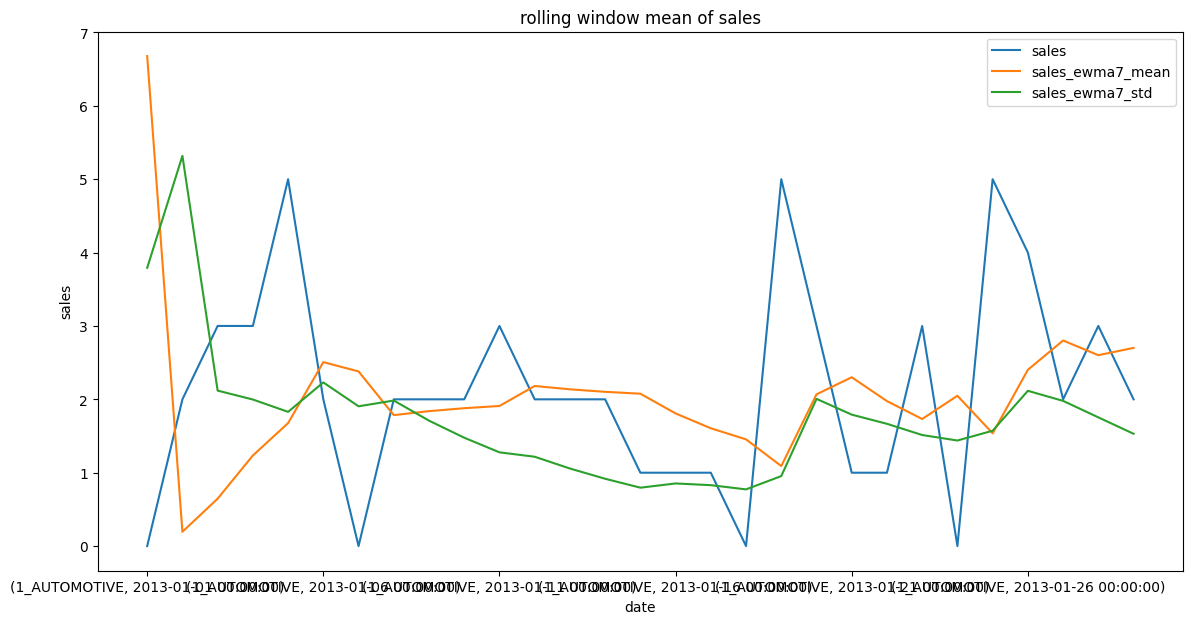

In [ ]:
cols = ["sales", "sales_ewma7_mean",	"sales_ewma7_std"]

ax = df.loc[("1_AUTOMOTIVE", '2013-01-01'):("1_AUTOMOTIVE", '2013-01-29')].loc[:, cols].plot(figsize=[14, 7])
 
ax.set_title("rolling window mean of sales")
ax.set_ylabel("sales")
ax.set_xlabel("date")

### 2 - Save the df with exponential weighted features

In [ ]:
# Set directory
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/enc_data")
data_dir.mkdir(exist_ok=True)

# Save the datasets with encoded features
out_dir = data_dir / "data_with_ewm_features.parquet"
df.to_parquet(path=out_dir, index=True)

## Step 2 - MEAN ENCODING

### 0 - Load the data

In [ ]:
# Directory containing the data with ewm features
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/enc_data/data_with_ewm_features.parquet")

# Load the base dataset
df = pd.read_parquet(
    path=data_dir, 
    engine="pyarrow"
)      

df 

store_nbr      family  sales  onpromotion  \
id            date                                                   
10_AUTOMOTIVE 2013-01-01        10  AUTOMOTIVE   0.00         0.00   
              2013-01-02        10  AUTOMOTIVE   3.00         0.00   
              2013-01-03        10  AUTOMOTIVE   2.00         0.00   
              2013-01-04        10  AUTOMOTIVE   2.00         0.00   
              2013-01-05        10  AUTOMOTIVE   0.00         0.00   
...                            ...         ...    ...          ...   
9_SEAFOOD     2017-08-27         9     SEAFOOD    NaN         0.00   
              2017-08-28         9     SEAFOOD    NaN         0.00   
              2017-08-29         9     SEAFOOD    NaN         0.00   
              2017-08-30         9     SEAFOOD    NaN         0.00   
              2017-08-31         9     SEAFOOD    NaN         0.00   

                          transactions  oil_price_interpolated   city  \
id            date                                                      
10_AUTOMOTIVE 2013-01-01          0.00                   93.14  Quito   
              2013-01-02       1293.00                   93.14  Quito   
              2013-01-03       1157.00                   92.97  Quito   
              2013-01-04        970.00                   93.12  Quito   
              2013-01-05       1269.00                   93.12  Quito   
...                                ...                     ...    ...   
9_SEAFOOD     2017-08-27           NaN                   46.40  Quito   
              2017-08-28           NaN                   46.40  Quito   
              2017-08-29           NaN                   46.46  Quito   
              2017-08-30           NaN                   45.96  Quito   
              2017-08-31           NaN                   47.26  Quito   

                              state type cluster is_Local_holiday  \
id            date                                                  
10_AUTOMOTIVE 2013-01-01  Pichincha    C      15       no_holiday   
              2013-01-02  Pichincha    C      15       no_holiday   
              2013-01-03  Pichincha    C      15       no_holiday   
              2013-01-04  Pichincha    C      15       no_holiday   
              2013-01-05  Pichincha    C      15       no_holiday   
...                             ...  ...     ...              ...   
9_SEAFOOD     2017-08-27  Pichincha    B       6       no_holiday   
              2017-08-28  Pichincha    B       6       no_holiday   
              2017-08-29  Pichincha    B       6       no_holiday   
              2017-08-30  Pichincha    B       6       no_holiday   
              2017-08-31  Pichincha    B       6       no_holiday   

                         is_Regional_holiday is_National_holiday wage_day  \
id            date                                                          
10_AUTOMOTIVE 2013-01-01          no_holiday            National      yes   
              2013-01-02          no_holiday          no_holiday       no   
              2013-01-03          no_holiday          no_holiday       no   
              2013-01-04          no_holiday          no_holiday       no   
              2013-01-05          no_holiday          no_holiday       no   
...                                      ...                 ...      ...   
9_SEAFOOD     2017-08-27          no_holiday          no_holiday       no   
              2017-08-28          no_holiday          no_holiday       no   
              2017-08-29          no_holiday          no_holiday       no   
              2017-08-30          no_holiday          no_holiday       no   
              2017-08-31          no_holiday          no_holiday       no   

                         earthquake_day earthquake_impact  sales_ewma7_mean  \
id            date                                                            
10_AUTOMOTIVE 2013-01-01             no                no               NaN   
              2013-01-02   

### 1 - Split df into train and test for mean encoding

In [ ]:
######## SPLIT df INTO train_ AND test_ FOR MEAN ENCODING ########

# train_ dataset: from 2017-01-01 to 2017-08-15
idx = pd.IndexSlice
train_ = df.query("date <= '2017-08-15'")               # train_ = df.loc[idx[:, idx['2013-01-01','2017-08-15']], :]

# test_ dataset: from 2017-01-01 to 2017-08-31 
#(Because we need the past data for the expanding window. We will delete the rows from the train dataset (2017-01-01 to 2017-08-15) after creating the encoded features)
test_ = df.copy()    

# Check: 
print(f"Train dataset for mean encoding is from {train_.index.min()[1]} to {train_.index.max()[1]}")
print(f"Test dataset for mean encoding is from {test_.index.min()[1]} to {test_.index.max()[1]} \n")

Train dataset for mean encoding is from 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test dataset for mean encoding is from 2013-01-01 00:00:00 to 2017-08-31 00:00:00 



### 2 - Mean encoding using expanding window: "family", "store_nbr", "city", "state", "type", "cluster"


In [ ]:
######## ENCODE ########
cols = [["family"], ["store_nbr"], ["city"], ["state"], ["type"], ["cluster"]]
train_dataframes = []
test_dataframes = []

for col in cols: 
  col_name = '_'.join(col)
  new_col_name = 'enc_' + col_name +'_mean'
    
  enc_train = (train_.groupby(col)["sales"].expanding(min_periods=1).mean().shift(periods=1)).reset_index()      
  enc_train = enc_train.rename(columns = {"sales": new_col_name})

  enc_test = (test_.groupby(col)["sales"].expanding(min_periods=1).mean().shift(periods=1)).reset_index()
  enc_test = enc_test.rename(columns = {"sales": new_col_name})

  train_dataframes.append(enc_train)
  test_dataframes.append(enc_test)
  
######## MERGE (to add encoded features to train_ dataset) ########
#Train dataset
all_enc_train = train_.reset_index().merge(train_dataframes[0])                
all_enc_train = all_enc_train.merge(train_dataframes[1])
all_enc_train = all_enc_train.merge(train_dataframes[2])
all_enc_train = all_enc_train.merge(train_dataframes[3])
all_enc_train = all_enc_train.merge(train_dataframes[4])
all_enc_train = all_enc_train.merge(train_dataframes[5])

#Test dataset
all_enc_test = test_.reset_index().merge(test_dataframes[0])
all_enc_test = all_enc_test.merge(test_dataframes[1])
all_enc_test = all_enc_test.merge(test_dataframes[2])
all_enc_test = all_enc_test.merge(test_dataframes[3])
all_enc_test = all_enc_test.merge(test_dataframes[4])
all_enc_test = all_enc_test.merge(test_dataframes[5])

######## DROP THE ORIGINAL FEATURES "city", "state", "type", "cluster"  +  SET INDEX  +  REMOVE ROWS FROM THE TEST DATASET ########
#Train dataset
all_enc_train = all_enc_train.drop(columns=["city", "state", "type", "cluster"])
all_enc_train = all_enc_train.set_index(["id", "date"])

#Test dataset
all_enc_test = all_enc_test.drop(columns=["city", "state", "type", "cluster"])
all_enc_test = all_enc_test.set_index(["id", "date"])

all_enc_test = all_enc_test.query("date > '2017-08-15'")                             #Remove rows that belongs to the train_ set                  


del train_, test_

### 3 - Save train_data, test_data, and full_data with encoded features for later steps

In [ ]:
train_data = reduce_memory_usage(df = all_enc_train).copy()
test_data = reduce_memory_usage(df=all_enc_test).copy()

print(f"Train dataset with encoded features: \n shape: {train_data.shape} \n from {train_data.index.min()[1]} to {train_data.index.max()[1]}"), display(train_data.head(5))
print(f"Test dataset with encoded features: \n shape: {test_data.shape} \n from {test_data.index.min()[1]} to {test_data.index.max()[1]}"), display(test_data.head(5))
del all_enc_train, all_enc_test

Memory usage decreased to 171.87 Mb (34.8% reduction)
Memory usage decreased to  2.01 Mb (24.5% reduction)
Train dataset with encoded features: 
 shape: (3000888, 20) 
 from 2013-01-01 00:00:00 to 2017-08-15 00:00:00


store_nbr      family  sales  onpromotion  \
id            date                                                   
10_AUTOMOTIVE 2013-01-01        10  AUTOMOTIVE   0.00         0.00   
              2013-01-02        10  AUTOMOTIVE   3.00         0.00   
              2013-01-03        10  AUTOMOTIVE   2.00         0.00   
              2013-01-04        10  AUTOMOTIVE   2.00         0.00   
              2013-01-05        10  AUTOMOTIVE   0.00         0.00   

                          transactions  oil_price_interpolated  \
id            date                                               
10_AUTOMOTIVE 2013-01-01          0.00                   93.14   
              2013-01-02       1293.00                   93.14   
              2013-01-03       1157.00                   92.97   
              2013-01-04        970.00                   93.12   
              2013-01-05       1269.00                   93.12   

                         is_Local_holiday is_Regional_holiday  \
id            date                                              
10_AUTOMOTIVE 2013-01-01       no_holiday          no_holiday   
              2013-01-02       no_holiday          no_holiday   
              2013-01-03       no_holiday          no_holiday   
              2013-01-04       no_holiday          no_holiday   
              2013-01-05       no_holiday          no_holiday   

                         is_National_holiday wage_day earthquake_day  \
id            date                                                     
10_AUTOMOTIVE 2013-01-01            National      yes             no   
              2013-01-02          no_holiday       no             no   
              2013-01-03          no_holiday       no             no   
              2013-01-04          no_holiday       no             no   
              2013-01-05          no_holiday       no             no   

                         earthquake_impact  sales_ewma7_mean  sales_ewma7_std  \
id            date                                                              
10_AUTOMOTIVE 2013-01-01                no               NaN              NaN   
              2013-01-02                no              0.00              NaN   
              2013-01-03                no              0.75             2.12   
              2013-01-04                no              1.06             1.63   
              2013-01-05                no              1.30             1.38   

                          enc_family_mean  enc_store_nbr_mean  enc_city_mean  \
id            date                                                             
10_AUTOMOTIVE 2013-01-01              NaN              254.53         255.14   
              2013-01-02             0.00                0.00           0.00   
              2013-01-03             1.50                1.50           1.50   
              2013-01-04             1.67                1.67           1.67   
              2013-01-05             1.75                1.75           1.75   

                          enc_state_mean  enc_type_mean  enc_cluster_mean  
id            date                                                         
10_AUTOMOTIVE 2013-01-01           73.60         326.74            708.23  
              2013-01-02            0.00           0.00              0.00  
              2013-01-03            1.50           1.50              1.50  
              2013-01-04            1.67           1.67              1.67  
              2013-01-05            1.75           1.75              1.75

Test dataset with encoded features: 
 shape: (28512, 20) 
 from 2017-08-16 00:00:00 to 2017-08-31 00:00:00


store_nbr      family  sales  onpromotion  \
id            date                                                   
10_AUTOMOTIVE 2017-08-16        10  AUTOMOTIVE    NaN         0.00   
              2017-08-17        10  AUTOMOTIVE    NaN         0.00   
              2017-08-18        10  AUTOMOTIVE    NaN         0.00   
              2017-08-19        10  AUTOMOTIVE    NaN         0.00   
              2017-08-20        10  AUTOMOTIVE    NaN         0.00   

                          transactions  oil_price_interpolated  \
id            date                                               
10_AUTOMOTIVE 2017-08-16           NaN                   46.80   
              2017-08-17           NaN                   47.07   
              2017-08-18           NaN                   48.59   
              2017-08-19           NaN                   48.58   
              2017-08-20           NaN                   47.98   

                         is_Local_holiday is_Regional_holiday  \
id            date                                              
10_AUTOMOTIVE 2017-08-16       no_holiday          no_holiday   
              2017-08-17       no_holiday          no_holiday   
              2017-08-18       no_holiday          no_holiday   
              2017-08-19       no_holiday          no_holiday   
              2017-08-20       no_holiday          no_holiday   

                         is_National_holiday wage_day earthquake_day  \
id            date                                                     
10_AUTOMOTIVE 2017-08-16          no_holiday       no             no   
              2017-08-17          no_holiday       no             no   
              2017-08-18          no_holiday       no             no   
              2017-08-19          no_holiday       no             no   
              2017-08-20          no_holiday       no             no   

                         earthquake_impact  sales_ewma7_mean  sales_ewma7_std  \
id            date                                                              
10_AUTOMOTIVE 2017-08-16                no              1.91             1.63   
              2017-08-17                no              1.91             1.63   
              2017-08-18                no              1.91             1.63   
              2017-08-19                no              1.91             1.63   
              2017-08-20                no              1.91             1.63   

                          enc_family_mean  enc_store_nbr_mean  enc_city_mean  \
id            date                                                             
10_AUTOMOTIVE 2017-08-16             3.08                3.08           3.08   
              2017-08-17             3.08                3.08           3.08   
              2017-08-18             3.08                3.08           3.08   
              2017-08-19             3.08                3.08           3.08   
              2017-08-20             3.08                3.08           3.08   

                          enc_state_mean  enc_type_mean  enc_cluster_mean  
id            date                                                         
10_AUTOMOTIVE 2017-08-16            3.08           3.08              3.08  
              2017-08-17            3.08           3.08              3.08  
              2017-08-18            3.08           3.08              3.08  
              2017-08-19            3.08           3.08              3.08  
              2017-08-20            3.08           3.08              3.08

In [ ]:
# Combine train_data and test_data
full_data = pd.concat([train_data, test_data])
full_data

store_nbr      family  sales  onpromotion  \
id            date                                                   
10_AUTOMOTIVE 2013-01-01        10  AUTOMOTIVE   0.00         0.00   
              2013-01-02        10  AUTOMOTIVE   3.00         0.00   
              2013-01-03        10  AUTOMOTIVE   2.00         0.00   
              2013-01-04        10  AUTOMOTIVE   2.00         0.00   
              2013-01-05        10  AUTOMOTIVE   0.00         0.00   
...                            ...         ...    ...          ...   
9_SEAFOOD     2017-08-27         9     SEAFOOD    NaN         0.00   
              2017-08-28         9     SEAFOOD    NaN         0.00   
              2017-08-29         9     SEAFOOD    NaN         0.00   
              2017-08-30         9     SEAFOOD    NaN         0.00   
              2017-08-31         9     SEAFOOD    NaN         0.00   

                          transactions  oil_price_interpolated  \
id            date                                               
10_AUTOMOTIVE 2013-01-01          0.00                   93.14   
              2013-01-02       1293.00                   93.14   
              2013-01-03       1157.00                   92.97   
              2013-01-04        970.00                   93.12   
              2013-01-05       1269.00                   93.12   
...                                ...                     ...   
9_SEAFOOD     2017-08-27           NaN                   46.40   
              2017-08-28           NaN                   46.40   
              2017-08-29           NaN                   46.46   
              2017-08-30           NaN                   45.96   
              2017-08-31           NaN                   47.26   

                         is_Local_holiday is_Regional_holiday  \
id            date                                              
10_AUTOMOTIVE 2013-01-01       no_holiday          no_holiday   
              2013-01-02       no_holiday          no_holiday   
              2013-01-03       no_holiday          no_holiday   
              2013-01-04       no_holiday          no_holiday   
              2013-01-05       no_holiday          no_holiday   
...                                   ...                 ...   
9_SEAFOOD     2017-08-27       no_holiday          no_holiday   
              2017-08-28       no_holiday          no_holiday   
              2017-08-29       no_holiday          no_holiday   
              2017-08-30       no_holiday          no_holiday   
              2017-08-31       no_holiday          no_holiday   

                         is_National_holiday wage_day earthquake_day  \
id            date                                                     
10_AUTOMOTIVE 2013-01-01            National      yes             no   
              2013-01-02          no_holiday       no             no   
              2013-01-03          no_holiday       no             no   
              2013-01-04          no_holiday       no             no   
              2013-01-05          no_holiday       no             no   
...                                      ...      ...            ...   
9_SEAFOOD     2017-08-27          no_holiday       no             no   
              2017-08-28          no_holiday       no             no   
              2017-08-29          no_holiday       no             no   
              2017-08-30          no_holiday       no             no   
              2017-08-31          no_holiday       no             no   

                         earthquake_impact  sales_ewma7_mean  sales_ewma7_std  \
id            date                                                              
10_AUTOMOTIVE 2013-01-01                no               NaN              NaN   
              2013-01-02                no              0.00              NaN   
              2013-01-03                no              0.75             2.12   
              2013-01-04                no              1.06       

In [ ]:
# tmp_ = full_data.loc["10_AUTOMOTIVE"]
# tmp_w = tmp_[['transactions']].transform(lambda x: x.shift(28).rolling(7).mean()).astype(np.float16)
# tmp_ws = tmp_[['transactions']].transform(lambda x: x.shift(28)).rolling(7).std().astype(np.float16)
# tmp_w.loc["2017-08-01":]

In [ ]:
# Reset index 
train_data = train_data.reset_index()
test_data = test_data.reset_index()
full_data = full_data.reset_index()

# Set directory
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/enc_data")
data_dir.mkdir(exist_ok=True)

# Save the datasets with ewm and encoded features
train_data_dir = data_dir / "train_data.parquet"
test_data_dir = data_dir / "test_data.parquet"
full_data_dir = data_dir / "full_data.parquet"

train_data.to_parquet(path=train_data_dir, index=False)
test_data.to_parquet(path=test_data_dir, index=False)
full_data.to_parquet(path=full_data_dir, index=False)